In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve
import lightgbm as lgb

In [2]:
# ML
## Verify lightgbm can run
from sklearn.model_selection import train_test_split

In [3]:
all_data = pd.read_csv('./src/all_data.csv', index_col=0)

In [4]:
feature_engineered = pd.read_csv('./src/potential_features.csv', index_col=0)

In [5]:
all_data.head()

APP_NAME_CONTRACT_TYPE  APP_CODE_GENDER_F  APP_CODE_GENDER_M  \
SK_ID_CURR                                                                 
100002                           1                0.0                1.0   
100003                           1                1.0                0.0   
100004                           0                0.0                1.0   
100006                           1                1.0                0.0   
100007                           1                0.0                1.0   

            APP_CODE_GENDER_XNA  APP_FLAG_OWN_CAR  APP_FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
100002                      0.0                 1                    1   
100003                      0.0                 1                    0   
100004                      0.0                 0                    1   
100006                      0.0                 1                    1   
100007                      0.0                 1                    1   

            APP_NAME_TYPE_SUITE_Children  APP_NAME_TYPE_SUITE_Family  \
SK_ID_CURR                                                             
100002                               0.0                         0.0   
100003                               0.0                         1.0   
100004                               0.0                         0.0   
100006                               0.0                         0.0   
100007                               0.0                         0.0   

            APP_NAME_TYPE_SUITE_Groupofpeople  APP_NAME_TYPE_SUITE_Other_A  \
SK_ID_CURR                                                                   
100002                                    0.0                          0.0   
100003                                    0.0                          0.0   
100004                                    0.0                          0.0   
100006                                    0.0                          0.0   
100007                                    0.0                          0.0   

            ...  normalized_days_to_instalment  \
SK_ID_CURR  ...                                  
100002      ...                       0.001767   
100003      ...                       0.000111   
100004      ...                       0.001080   
100006      ...                       0.000308   
100007      ...                       0.000287   

            normalized_days_to_instalment_binary_01  \
SK_ID_CURR                                            
100002                                            0   
100003                                            0   
100004                                            0   
100006                                            0   
100007                                            0   

            normalized_days_to_instalment_binary_03  \
SK_ID_CURR                                            
100002                                            1   
100003                                            1   
100004                                            1   
100006                                            1   
100007                                            1   

            normalized_days_to_instalment_binary_06  \
SK_ID_CURR                                            
100002                                            1   
100003                                            1   
100004                                            1   
100006                                            1   
100007                                            1   

            payment_relative_income_binary_03  \
SK_ID_CURR                                      
100002                                      1   
100003                                      1   
100004                                      0   
100006                                      1   
100007                                      1   

            payment_relative_income_binary_07  avg_cred

## Train Test Split

In [6]:
train, test = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['TARGET'])

## LGBM for feature filtering

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 77895
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 705
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

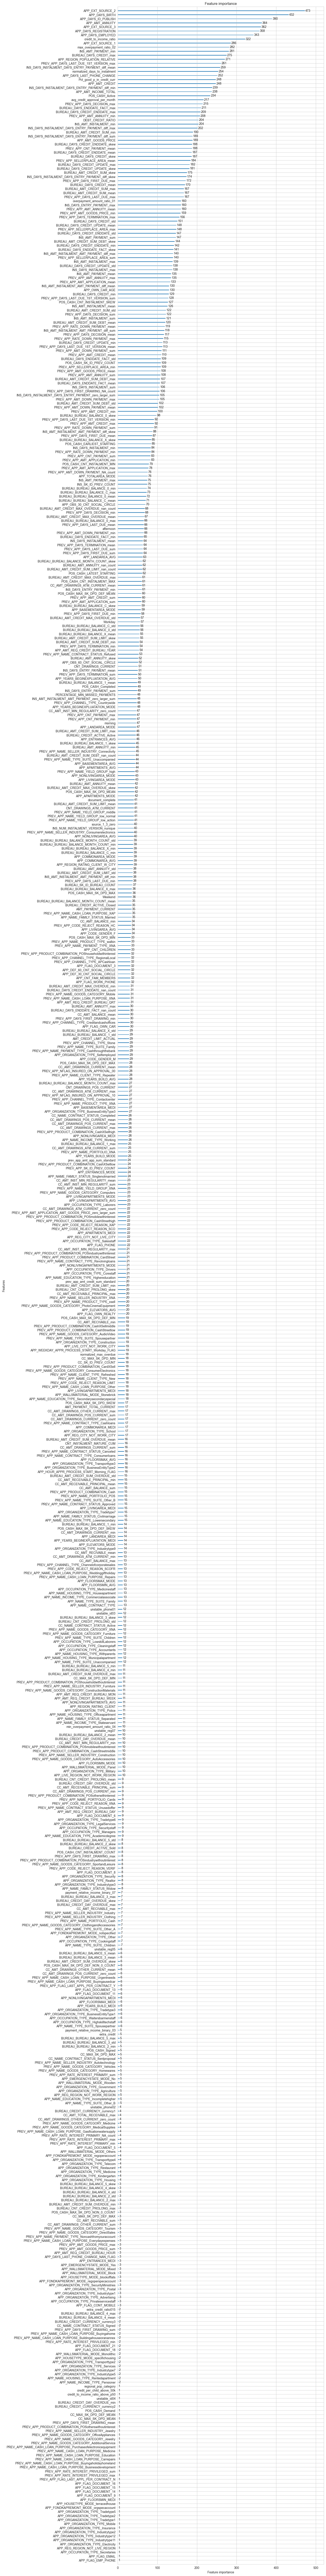

In [7]:
# load data using lightgbm
train_data = lgb.Dataset(train.drop('TARGET', axis=1), label=train['TARGET'])
# lightgbm parameters
params = {"force_col_wise": True, 'random_state': 42, 'objective': 'binary', 'metric': 'auc',
          'n_jobs': 1}  # njobs = 1 to avoid multithreading, keep reproducability
# lightgbm training
gbm = lgb.train(params, train_data, num_boost_round=1000)
# plot feature importance
lgb.plot_importance(gbm, figsize=(12, 150))

## Select important features

In [8]:
# select the top 100 features
feature_importance = pd.DataFrame()
feature_importance['Feature'] = all_data.drop('TARGET',axis=1).columns
feature_importance['Importance'] = gbm.feature_importance()

In [9]:
important_features = pd.DataFrame(gbm.feature_importance(), index=train.drop('TARGET',axis=1).columns, columns=['importance']).sort_values(
    by='importance', ascending=False)
# important_features['importance'] = important_features['importance'] / important_features['importance'].sum()
important_features_name = important_features[important_features['importance'] >3].index.tolist()

In [10]:
len(important_features_name)

537

In [11]:
important_features

importance
APP_EXT_SOURCE_2                            473
APP_DAYS_BIRTH                              432
APP_DAYS_ID_PUBLISH                         390
APP_AMT_ANNUITY                             364
APP_EXT_SOURCE_3                            362
...                                         ...
PREV_APP_RATE_INTEREST_PRIMARY_mean           0
APP_OCCUPATION_TYPE_Realtyagents              0
PREV_APP_RATE_DOWN_PAYMENT_NA_count           0
BUREAU_CREDIT_CURRENCY_currency4              0
APP_DAYS_EMPLOYED_NAN_FLAG                    0

[739 rows x 1 columns]

## Feature Engineering Passed Default LightGBM Features

In [12]:
important_features.loc[np.intersect1d(important_features_name, feature_engineered.columns)].sort_values(by='importance', ascending=False)

importance
max_overpayment_ratio_02                  282
normalized_days_to_instalment             254
Pct_good_p_in_credit_curr                 248
avg_credit_approval_per_month             217
DEBT_CREDIT_RATIO                         204
overpayment_amount_ratio_01               160
PERCENTAGE_MIN_MISSED_PAYMENTS             48
document_complete                          41
source_1_3_zero                            40
normalized_max_overdue                     18
unstable_id03                              12
unstable_phone01                           12
min_overpayment_amount_ratio_04            10
unstable_reg07                             10
payment_relative_income_binary_07           7
unstable_reg05                              6
payment_relative_income_binary_03           5
extra_credit                                5
unstable_phone02                            4

In [13]:
len(feature_engineered.columns)

29

In [14]:
# only use important feature to train and test

## Default LightGBM

### Train

In [15]:
train_data = lgb.Dataset(train[important_features_name], label=train['TARGET'])

In [16]:
gbm = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


In [17]:
def ROC_plot(model,model_name):
    pred = model.predict(test[important_features_name])
    fpr, tpr, thresholds = roc_curve(test['TARGET'], pred)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(test["TARGET"], pred):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'OOS ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

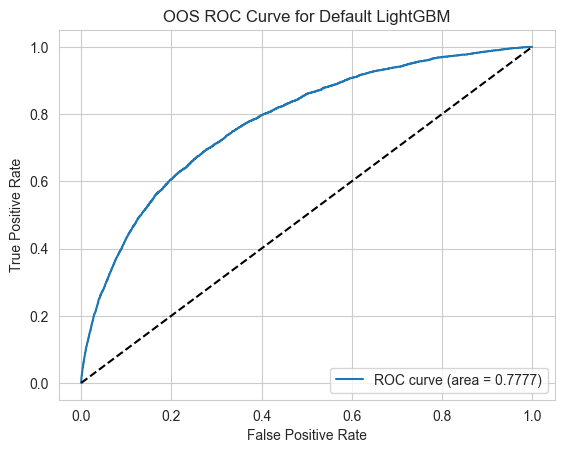

In [18]:
ROC_plot(gbm,'Default LightGBM')

### Onboarding Profit

In [19]:
# from profit on boarding
application_pnl = pd.read_csv('./src/application_character_with_pnl.csv', index_col=0)
application = pd.read_csv('./src/application_train.csv', index_col=0)

In [20]:
application_pnl.head()

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                                      
100002         0.090032    0.090287         0.077441                 0.434783   
100003         0.132924    0.311736         0.271605                 0.478261   
100004         0.020025    0.022472         0.023569                 0.391304   
100006         0.109477    0.066837         0.063973                 0.739130   
100007         0.078975    0.116854         0.117845                 0.478261   

            NAME_TYPE_SUITE  WEEKDAY_APPR_PROCESS_START  Distance  TARGET  \
SK_ID_CURR                                                                  
100002             0.000000                    0.333333  1.025875       1   
100003             0.166667                    0.000000  1.361192       0   
100004             0.000000                    0.000000  0.457370       0   
100006             0.000000                    0.333333  1.312751       0   
100007             0.000000                    0.500000  1.291935       0   

           NAME_CONTRACT_TYPE  CLOSEST_PREVIOUS_LOAN_PROFIT  
SK_ID_CURR                                                   
100002             Cash loans                -350635.125590  
100003             Cash loans                 497317.952788  
100004        Revolving loans                    200.763725  
100006             Cash loans                  49068.551471  
100007             Cash loans                 123169.954206

In [87]:
def onboarding_profit_margin(pred,thresholds):
    profit =application_pnl.loc[test.index]['CLOSEST_PREVIOUS_LOAN_PROFIT'].values
    loan_amount = application.loc[test.index]['AMT_CREDIT'].values
    return [((pred<th).astype(int)*profit).sum()/((pred<th).astype(int)*loan_amount).sum() for th in thresholds]
def onboarding_loan_amount(pred,thresholds):
    loan_amount = application.loc[test.index]['AMT_CREDIT'].values
    return [((pred<th).astype(int)*loan_amount).sum() for th in thresholds]

In [89]:
def Onboarding_plot(model,model_name):
    pred = model.predict(test[important_features_name])
    _, _, thresholds = roc_curve(test['TARGET'], pred)
    profit_margin = onboarding_profit_margin(pred, thresholds)
    loan_amount = onboarding_loan_amount(pred, thresholds)
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Thresholds')
    ax1.set_ylabel('Expected Profit Margin', color=color)
    ax1.plot(thresholds, profit_margin, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Loan Amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(thresholds, loan_amount, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Onboarding Profit Margin and Loan Amount for {model_name}')
    plt.xlim(0,1)
    plt.show()

In [90]:
Onboarding_plot(gbm,'Default LightGBM')

C:\Users\kevin\AppData\Local\Temp\ipykernel_4460\2982743558.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return [((pred<th).astype(int)*profit).sum()/((pred<th).astype(int)*loan_amount).sum() for th in thresholds]


## Lightgbm Tuning

In [24]:
from optuna.integration.lightgbm import LightGBMTunerCV as tunerCV

params = {"force_col_wise": True, 'random_state': 42, 'objective': 'binary', 'metric': 'auc'}
train_data = lgb.Dataset(train[important_features_name], label=train['TARGET'])
gbm_tuned_cv = tunerCV(params, train_data, num_boost_round=1000, verbose_eval=100, early_stopping_rounds=10,nfold=5,return_cvbooster=True,stratified=True,seed=42)

[I 2024-01-04 18:09:30,458] A new study created in memory with name: no-name-f087780e-136e-4967-84a3-87ab8b9821d4


In [25]:
gbm_tuned_cv.run()

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction, val_score: 0.780160:  14%|#4        | 1/7 [01:08<06:53, 68.92s/it]

Early stopping, best iteration is:
[115]	cv_agg's valid auc: 0.78016 + 0.00247781
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Li

feature_fraction, val_score: 0.780283:  29%|##8       | 2/7 [02:34<06:32, 78.56s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction, val_score: 0.780503:  43%|####2     | 3/7 [03:38<04:48, 72.22s/it]

Early stopping, best iteration is:
[126]	cv_agg's valid auc: 0.780503 + 0.002212
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Lig

feature_fraction, val_score: 0.780941:  43%|####2     | 3/7 [04:52<04:48, 72.22s/it]

Early stopping, best iteration is:
[139]	cv_agg's valid auc: 0.780941 + 0.00208127


feature_fraction, val_score: 0.780941:  57%|#####7    | 4/7 [04:52<03:38, 72.96s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction, val_score: 0.780947:  71%|#######1  | 5/7 [05:56<02:18, 69.49s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction, val_score: 0.780947:  86%|########5 | 6/7 [07:00<01:07, 67.60s/it][I 2024-01-04 18:16:30,925] Trial 5 finished with value: 0.7807517168058267 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.7809466638579429.


Early stopping, best iteration is:
[141]	cv_agg's valid auc: 0.780752 + 0.00264345


feature_fraction, val_score: 0.780947:  86%|########5 | 6/7 [07:00<01:07, 67.60s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction, val_score: 0.781018:  86%|########5 | 6/7 [08:07<01:07, 67.60s/it]

Early stopping, best iteration is:
[151]	cv_agg's valid auc: 0.781018 + 0.00254728


num_leaves, val_score: 0.781018:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.781018:   5%|5         | 1/20 [01:39<31:25, 99.22s/it]

Early stopping, best iteration is:
[89]	cv_agg's valid auc: 0.774164 + 0.00161315


[I 2024-01-04 18:19:17,013] Trial 7 finished with value: 0.774163564934671 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 0.774163564934671.
num_leaves, val_score: 0.781018:   5%|5         | 1/20 [01:39<31:25, 99.22s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.781018:  10%|#         | 2/20 [03:08<28:04, 93.57s/it]

Early stopping, best iteration is:
[85]	cv_agg's valid auc: 0.773815 + 0.00137423


[I 2024-01-04 18:20:46,639] Trial 8 finished with value: 0.773815498123632 and parameters: {'num_leaves': 158}. Best is trial 7 with value: 0.774163564934671.
num_leaves, val_score: 0.781018:  10%|#         | 2/20 [03:09<28:04, 93.57s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.781018:  15%|#5        | 3/20 [05:03<29:14, 103.19s/it]

Early stopping, best iteration is:
[107]	cv_agg's valid auc: 0.773369 + 0.00196515


[I 2024-01-04 18:22:41,287] Trial 9 finished with value: 0.7733688955469472 and parameters: {'num_leaves': 177}. Best is trial 7 with value: 0.774163564934671.
num_leaves, val_score: 0.781018:  15%|#5        | 3/20 [05:03<29:14, 103.19s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  20%|##        | 4/20 [06:49<27:49, 104.32s/it]

[500]	cv_agg's valid auc: 0.783244 + 0.00298336
Early stopping, best iteration is:
[491]	cv_agg's valid auc: 0.783295 + 0.00293724
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negati

num_leaves, val_score: 0.783295:  25%|##5       | 5/20 [08:13<24:12, 96.80s/it]

Early stopping, best iteration is:
[299]	cv_agg's valid auc: 0.782505 + 0.00259579
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

num_leaves, val_score: 0.783295:  30%|###       | 6/20 [09:20<20:16, 86.86s/it]

Early stopping, best iteration is:
[148]	cv_agg's valid auc: 0.781593 + 0.00244804
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

num_leaves, val_score: 0.783295:  35%|###5      | 7/20 [11:10<20:26, 94.34s/it]

[500]	cv_agg's valid auc: 0.783244 + 0.00298336
Early stopping, best iteration is:
[491]	cv_agg's valid auc: 0.783295 + 0.00293724


[I 2024-01-04 18:28:48,003] Trial 13 finished with value: 0.7832950731901436 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  35%|###5      | 7/20 [11:10<20:26, 94.34s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  40%|####      | 8/20 [12:37<18:23, 91.99s/it]

Early stopping, best iteration is:
[114]	cv_agg's valid auc: 0.777926 + 0.00179022


[I 2024-01-04 18:30:14,992] Trial 14 finished with value: 0.7779258342888606 and parameters: {'num_leaves': 70}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  40%|####      | 8/20 [12:37<18:23, 91.99s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  45%|####5     | 9/20 [13:52<15:53, 86.65s/it]

Early stopping, best iteration is:
[91]	cv_agg's valid auc: 0.777281 + 0.00158174


[I 2024-01-04 18:31:29,926] Trial 15 finished with value: 0.7772813188308374 and parameters: {'num_leaves': 81}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  45%|####5     | 9/20 [13:52<15:53, 86.65s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  50%|#####     | 10/20 [16:15<17:22, 104.30s/it]

Early stopping, best iteration is:
[105]	cv_agg's valid auc: 0.77139 + 0.00297723


[I 2024-01-04 18:33:53,853] Trial 16 finished with value: 0.7713898240243761 and parameters: {'num_leaves': 227}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  50%|#####     | 10/20 [16:16<17:22, 104.30s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  55%|#####5    | 11/20 [17:43<14:52, 99.21s/it] 

Early stopping, best iteration is:
[106]	cv_agg's valid auc: 0.778185 + 0.00204018


[I 2024-01-04 18:35:21,401] Trial 17 finished with value: 0.7781852710224632 and parameters: {'num_leaves': 74}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  55%|#####5    | 11/20 [17:43<14:52, 99.21s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  60%|######    | 12/20 [20:56<17:02, 127.79s/it]

[1000]	cv_agg's valid auc: 0.782778 + 0.00237133
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid auc: 0.782778 + 0.00237133
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, n

num_leaves, val_score: 0.783295:  65%|######5   | 13/20 [22:19<13:18, 114.11s/it]

Early stopping, best iteration is:
[124]	cv_agg's valid auc: 0.779598 + 0.00252673


[I 2024-01-04 18:39:57,186] Trial 19 finished with value: 0.7795975696993309 and parameters: {'num_leaves': 47}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  65%|######5   | 13/20 [22:19<13:18, 114.11s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  70%|#######   | 14/20 [23:58<10:56, 109.41s/it]

Early stopping, best iteration is:
[91]	cv_agg's valid auc: 0.775992 + 0.00169784


[I 2024-01-04 18:41:35,779] Trial 20 finished with value: 0.7759917964125823 and parameters: {'num_leaves': 112}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  70%|#######   | 14/20 [23:58<10:56, 109.41s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  75%|#######5  | 15/20 [26:44<10:33, 126.71s/it]

[1000]	cv_agg's valid auc: 0.776031 + 0.00253587
Did not meet early stopping. Best iteration is:
[1000]	cv_agg's valid auc: 0.776031 + 0.00253587
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, n

num_leaves, val_score: 0.783295:  80%|########  | 16/20 [28:00<07:25, 111.36s/it]

Early stopping, best iteration is:
[137]	cv_agg's valid auc: 0.780527 + 0.00219273


[I 2024-01-04 18:45:38,244] Trial 22 finished with value: 0.7805268663553524 and parameters: {'num_leaves': 38}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  80%|########  | 16/20 [28:00<07:25, 111.36s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  85%|########5 | 17/20 [30:20<05:59, 119.92s/it]

Early stopping, best iteration is:
[619]	cv_agg's valid auc: 0.782503 + 0.0022454
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Li

num_leaves, val_score: 0.783295:  90%|######### | 18/20 [31:33<03:32, 106.01s/it]

Early stopping, best iteration is:
[129]	cv_agg's valid auc: 0.78015 + 0.00274883


[I 2024-01-04 18:49:11,723] Trial 24 finished with value: 0.7801503646337908 and parameters: {'num_leaves': 37}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  90%|######### | 18/20 [31:34<03:32, 106.01s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295:  95%|#########5| 19/20 [33:11<01:43, 103.51s/it]

Early stopping, best iteration is:
[104]	cv_agg's valid auc: 0.776686 + 0.00231506


[I 2024-01-04 18:50:49,425] Trial 25 finished with value: 0.776685830604544 and parameters: {'num_leaves': 105}. Best is trial 10 with value: 0.7832950731901436.
num_leaves, val_score: 0.783295:  95%|#########5| 19/20 [33:11<01:43, 103.51s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

num_leaves, val_score: 0.783295: 100%|##########| 20/20 [34:37<00:00, 98.31s/it] 

Early stopping, best iteration is:
[120]	cv_agg's valid auc: 0.778634 + 0.00234963


[I 2024-01-04 18:52:15,605] Trial 26 finished with value: 0.7786338549321637 and parameters: {'num_leaves': 53}. Best is trial 10 with value: 0.7832950731901436.
bagging, val_score: 0.783295:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

bagging, val_score: 0.783295:  10%|#         | 1/10 [01:39<14:58, 99.81s/it][I 2024-01-04 18:53:57,685] Trial 27 finished with value: 0.7824428941492835 and parameters: {'bagging_fraction': 0.8681118024519573, 'bagging_freq': 5}. Best is trial 27 with value: 0.7824428941492835.


Early stopping, best iteration is:
[369]	cv_agg's valid auc: 0.782443 + 0.00292854


bagging, val_score: 0.783295:  10%|#         | 1/10 [01:39<14:58, 99.81s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

bagging, val_score: 0.783295:  20%|##        | 2/10 [02:37<10:02, 75.29s/it][I 2024-01-04 18:54:55,811] Trial 28 finished with value: 0.7805669661034439 and parameters: {'bagging_fraction': 0.4057712328182761, 'bagging_freq': 1}. Best is trial 27 with value: 0.7824428941492835.


Early stopping, best iteration is:
[323]	cv_agg's valid auc: 0.780567 + 0.00280045


bagging, val_score: 0.783295:  20%|##        | 2/10 [02:38<10:02, 75.29s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

bagging, val_score: 0.783295:  30%|###       | 3/10 [04:08<09:34, 82.04s/it]

Early stopping, best iteration is:
[355]	cv_agg's valid auc: 0.782319 + 0.00263925
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783295:  40%|####      | 4/10 [05:11<07:28, 74.72s/it]

Early stopping, best iteration is:
[333]	cv_agg's valid auc: 0.781538 + 0.00244105
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783295:  50%|#####     | 5/10 [06:22<06:07, 73.41s/it]

Early stopping, best iteration is:
[362]	cv_agg's valid auc: 0.782403 + 0.00216515
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783295:  60%|######    | 6/10 [08:05<05:33, 83.46s/it]

Early stopping, best iteration is:
[454]	cv_agg's valid auc: 0.783204 + 0.00235239
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783295:  70%|#######   | 7/10 [09:28<04:09, 83.21s/it]

Early stopping, best iteration is:
[331]	cv_agg's valid auc: 0.781465 + 0.00243336
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783295:  80%|########  | 8/10 [11:00<02:51, 85.96s/it]

Early stopping, best iteration is:
[453]	cv_agg's valid auc: 0.783148 + 0.00166701
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783666:  90%|######### | 9/10 [12:34<01:28, 88.70s/it]

Early stopping, best iteration is:
[468]	cv_agg's valid auc: 0.783666 + 0.00192769
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

bagging, val_score: 0.783666: 100%|##########| 10/10 [14:03<00:00, 84.40s/it]

Early stopping, best iteration is:
[380]	cv_agg's valid auc: 0.782519 + 0.0019948



feature_fraction_stage2, val_score: 0.783666:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction_stage2, val_score: 0.783666:  17%|#6        | 1/6 [01:21<06:48, 81.64s/it]

Early stopping, best iteration is:
[386]	cv_agg's valid auc: 0.782756 + 0.00203733
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

feature_fraction_stage2, val_score: 0.783666:  33%|###3      | 2/6 [02:58<06:02, 90.50s/it]

Early stopping, best iteration is:
[434]	cv_agg's valid auc: 0.783216 + 0.00190668
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

feature_fraction_stage2, val_score: 0.783666:  50%|#####     | 3/6 [04:33<04:36, 92.33s/it]

Early stopping, best iteration is:
[454]	cv_agg's valid auc: 0.783262 + 0.00203808
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

feature_fraction_stage2, val_score: 0.783666:  67%|######6   | 4/6 [05:55<02:57, 88.51s/it]

Early stopping, best iteration is:
[386]	cv_agg's valid auc: 0.782656 + 0.00239675
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

feature_fraction_stage2, val_score: 0.783666:  83%|########3 | 5/6 [08:01<01:42, 102.10s/it]

Early stopping, best iteration is:
[510]	cv_agg's valid auc: 0.783561 + 0.00199012


[I 2024-01-04 19:14:24,888] Trial 41 finished with value: 0.7835614490092476 and parameters: {'feature_fraction': 0.62}. Best is trial 41 with value: 0.7835614490092476.
feature_fraction_stage2, val_score: 0.783666:  83%|########3 | 5/6 [08:01<01:42, 102.10s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

feature_fraction_stage2, val_score: 0.783666: 100%|##########| 6/6 [10:08<00:00, 110.56s/it]

Early stopping, best iteration is:
[470]	cv_agg's valid auc: 0.783051 + 0.00226287


[I 2024-01-04 19:16:31,891] Trial 42 finished with value: 0.7830508598190246 and parameters: {'feature_fraction': 0.748}. Best is trial 41 with value: 0.7835614490092476.
regularization_factors, val_score: 0.783666:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

regularization_factors, val_score: 0.785703:   5%|5         | 1/20 [02:22<45:03, 142.28s/it]

Early stopping, best iteration is:
[495]	cv_agg's valid auc: 0.785703 + 0.00188121
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.785703:  10%|#         | 2/20 [04:26<39:30, 131.67s/it]

Early stopping, best iteration is:
[453]	cv_agg's valid auc: 0.785245 + 0.00176521


[I 2024-01-04 19:20:58,609] Trial 44 finished with value: 0.7852453509224253 and parameters: {'lambda_l1': 6.019777022513037e-07, 'lambda_l2': 7.825512671825283}. Best is trial 43 with value: 0.7857025841336397.
regularization_factors, val_score: 0.785703:  10%|#         | 2/20 [04:26<39:30, 131.67s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

regularization_factors, val_score: 0.785703:  15%|#5        | 3/20 [06:28<36:01, 127.14s/it]

Early stopping, best iteration is:
[451]	cv_agg's valid auc: 0.785501 + 0.0020983
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Li

regularization_factors, val_score: 0.785832:  20%|##        | 4/20 [08:26<33:00, 123.78s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

regularization_factors, val_score: 0.786288:  25%|##5       | 5/20 [10:58<33:28, 133.89s/it][I 2024-01-04 19:27:30,624] Trial 47 finished with value: 0.786287997958978 and parameters: {'lambda_l1': 6.432619159268164e-07, 'lambda_l2': 9.389873337050233}. Best is trial 47 with value: 0.786287997958978.


Early stopping, best iteration is:
[559]	cv_agg's valid auc: 0.786288 + 0.00201158


regularization_factors, val_score: 0.786288:  25%|##5       | 5/20 [10:58<33:28, 133.89s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

regularization_factors, val_score: 0.786288:  30%|###       | 6/20 [13:19<31:47, 136.23s/it]

Early stopping, best iteration is:
[561]	cv_agg's valid auc: 0.786116 + 0.0021323
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Li

regularization_factors, val_score: 0.786577:  35%|###5      | 7/20 [15:37<29:37, 136.75s/it]

Early stopping, best iteration is:
[580]	cv_agg's valid auc: 0.786577 + 0.00204966
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786577:  40%|####      | 8/20 [17:25<25:31, 127.66s/it]

Early stopping, best iteration is:
[454]	cv_agg's valid auc: 0.785242 + 0.00175879
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786577:  45%|####5     | 9/20 [19:35<23:31, 128.36s/it]

Early stopping, best iteration is:
[554]	cv_agg's valid auc: 0.786167 + 0.00210574
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786608:  50%|#####     | 10/20 [21:49<21:39, 129.99s/it]

Early stopping, best iteration is:
[596]	cv_agg's valid auc: 0.786608 + 0.00198715
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  55%|#####5    | 11/20 [23:47<18:57, 126.34s/it]

Early stopping, best iteration is:
[580]	cv_agg's valid auc: 0.786652 + 0.00183829
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  60%|######    | 12/20 [25:35<16:06, 120.75s/it]

Early stopping, best iteration is:
[519]	cv_agg's valid auc: 0.785995 + 0.00167918
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  65%|######5   | 13/20 [27:46<14:28, 124.01s/it]

Early stopping, best iteration is:
[598]	cv_agg's valid auc: 0.786348 + 0.00228784
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  70%|#######   | 14/20 [29:20<11:29, 114.93s/it]

Early stopping, best iteration is:
[453]	cv_agg's valid auc: 0.783463 + 0.00226785
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  75%|#######5  | 15/20 [30:57<09:07, 109.46s/it]

Early stopping, best iteration is:
[468]	cv_agg's valid auc: 0.783667 + 0.00192772
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  80%|########  | 16/20 [32:22<06:48, 102.01s/it]

Early stopping, best iteration is:
[415]	cv_agg's valid auc: 0.783645 + 0.00209308
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  85%|########5 | 17/20 [34:00<05:02, 100.97s/it]

[500]	cv_agg's valid auc: 0.784187 + 0.00177744
Early stopping, best iteration is:
[490]	cv_agg's valid auc: 0.784199 + 0.00180428
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negati

regularization_factors, val_score: 0.786652:  90%|######### | 18/20 [35:32<03:16, 98.10s/it]

Early stopping, best iteration is:
[433]	cv_agg's valid auc: 0.784253 + 0.00210394
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652:  95%|#########5| 19/20 [37:12<01:38, 98.81s/it]

Early stopping, best iteration is:
[470]	cv_agg's valid auc: 0.784709 + 0.00243305
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[L

regularization_factors, val_score: 0.786652: 100%|##########| 20/20 [39:12<00:00, 105.24s/it]

Early stopping, best iteration is:
[511]	cv_agg's valid auc: 0.784821 + 0.00249934


[I 2024-01-04 19:55:44,817] Trial 62 finished with value: 0.784821223263568 and parameters: {'lambda_l1': 6.140655337825277e-06, 'lambda_l2': 1.365288044878782}. Best is trial 53 with value: 0.7866518423329325.
min_data_in_leaf, val_score: 0.786652:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

min_data_in_leaf, val_score: 0.786652:  20%|##        | 1/5 [01:44<06:58, 104.57s/it]

Early stopping, best iteration is:
[520]	cv_agg's valid auc: 0.786325 + 0.00181373


[I 2024-01-04 19:57:31,852] Trial 63 finished with value: 0.7863250055711124 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.7863250055711124.
min_data_in_leaf, val_score: 0.786652:  20%|##        | 1/5 [01:44<06:58, 104.57s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

min_data_in_leaf, val_score: 0.786652:  40%|####      | 2/5 [03:34<05:23, 107.77s/it][I 2024-01-04 19:59:21,841] Trial 64 finished with value: 0.7864469273546849 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.7864469273546849.


Early stopping, best iteration is:
[551]	cv_agg's valid auc: 0.786447 + 0.00201073


min_data_in_leaf, val_score: 0.786652:  40%|####      | 2/5 [03:34<05:23, 107.77s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

min_data_in_leaf, val_score: 0.786652:  60%|######    | 3/5 [05:23<03:36, 108.22s/it]

Early stopping, best iteration is:
[551]	cv_agg's valid auc: 0.786447 + 0.00201073


[I 2024-01-04 20:01:10,614] Trial 65 finished with value: 0.7864469273546849 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.7864469273546849.
min_data_in_leaf, val_score: 0.786652:  60%|######    | 3/5 [05:23<03:36, 108.22s/it]

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used feat

min_data_in_leaf, val_score: 0.786670:  80%|########  | 4/5 [07:20<01:51, 111.94s/it]

Early stopping, best iteration is:
[581]	cv_agg's valid auc: 0.78667 + 0.0017531
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 537
[LightGBM] [Info] Number of positive: 15888, number of negative: 180919
[LightGBM] [Info] Total Bins 71923
[Lig

min_data_in_leaf, val_score: 0.786670: 100%|##########| 5/5 [09:18<00:00, 111.76s/it]

Early stopping, best iteration is:
[580]	cv_agg's valid auc: 0.786624 + 0.00182501


In [26]:
with open('./src/lightgbm_tuned_cv.txt', 'w') as f:
    f.write(str(gbm_tuned_cv.best_params))

In [27]:
import pickle
with open('./src/lightgbm_tuned_cv.pkl', 'wb') as f:
    pickle.dump(gbm_tuned_cv, f)

In [28]:
gbm_tuned_cv.get_best_booster().save_model('./src/lightgbm_tuned_cv.txt')

In [31]:
gbm_tuned_cv.best_score

0.7866699644594988

In [32]:
gbm_tuned_cv.best_params

{'force_col_wise': True,
 'random_state': 42,
 'objective': 'binary',
 'metric': 'auc',
 'feature_pre_filter': False,
 'lambda_l1': 6.931602168547142e-07,
 'lambda_l2': 8.369887266722193,
 'num_leaves': 6,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.816595323327872,
 'bagging_freq': 3,
 'min_child_samples': 100}

In [36]:
gbm_tuned_param_model = lgb.train(gbm_tuned_cv.best_params, train_data, num_boost_round=1000)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Total Bins 71923
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


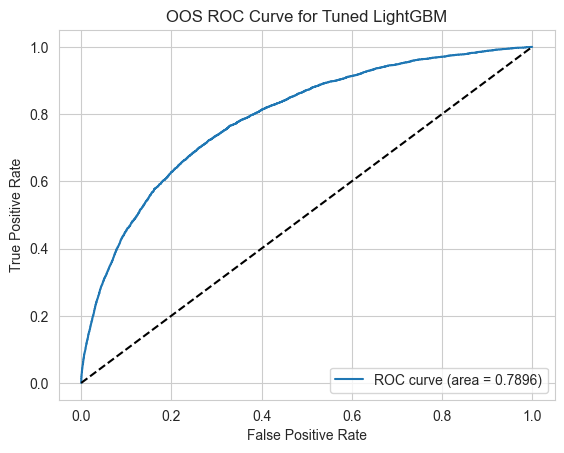

In [37]:
ROC_plot(gbm_tuned_param_model,'Tuned LightGBM')

C:\Users\kevin\AppData\Local\Temp\ipykernel_4460\2027899338.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return [((pred<th).astype(int)*profit).sum()/((pred<th).astype(int)*loan_amount).sum() for th in thresholds]


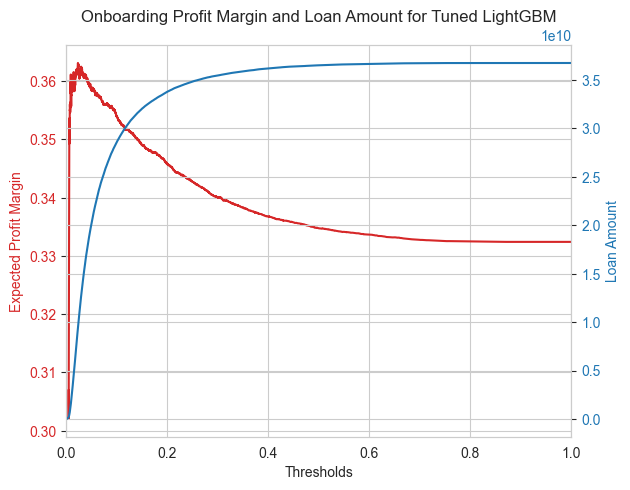

In [61]:
Onboarding_plot(gbm_tuned_param_model,'Tuned LightGBM')

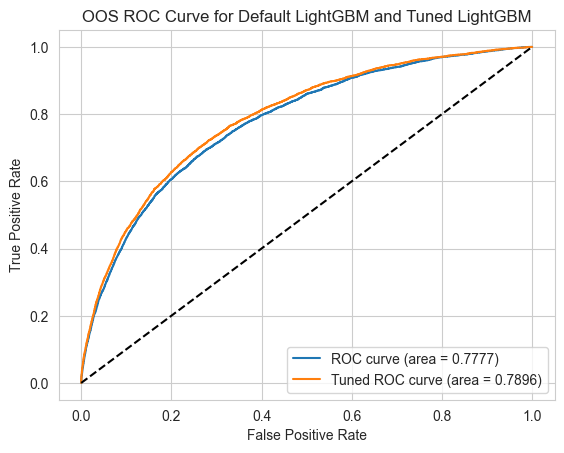

In [92]:
# plot two models together
pred = gbm.predict(test[important_features_name])
pred_tuned = gbm_tuned_param_model.predict(test[important_features_name])
fpr, tpr, thresholds = roc_curve(test['TARGET'], pred)
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(test['TARGET'], pred_tuned)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(test["TARGET"], pred):.4f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned ROC curve (area = {roc_auc_score(test["TARGET"], pred_tuned):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'OOS ROC Curve for Default LightGBM and Tuned LightGBM')
plt.legend(loc="lower right")
plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_4460\2982743558.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return [((pred<th).astype(int)*profit).sum()/((pred<th).astype(int)*loan_amount).sum() for th in thresholds]


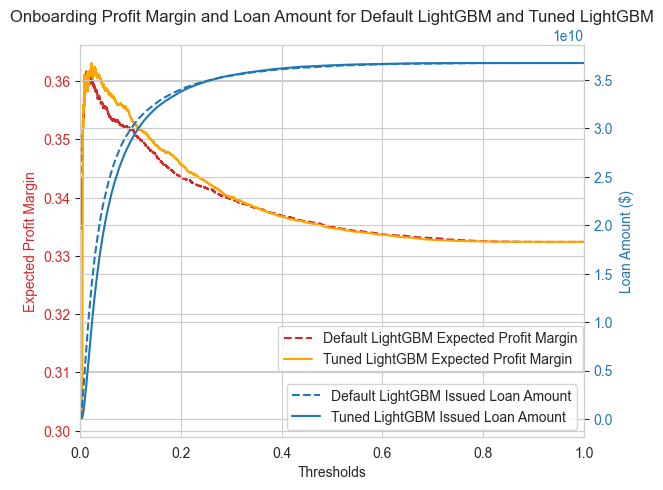

In [91]:
# plot onboarding profit margin and loan amount for two models together
_, _, thresholds = roc_curve(test['TARGET'], pred)
_, _, thresholds_tuned = roc_curve(test['TARGET'], pred_tuned)
profit_margin = onboarding_profit_margin(pred, thresholds)
loan_amount = onboarding_loan_amount(pred, thresholds)
profit_margin_tuned = onboarding_profit_margin(pred_tuned, thresholds_tuned)
loan_amount_tuned = onboarding_loan_amount(pred_tuned, thresholds_tuned)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Thresholds')
ax1.set_ylabel('Expected Profit Margin', color=color)
ax1.plot(thresholds, profit_margin, color=color,label='Default LightGBM Expected Profit Margin',linestyle='dashed')
ax1.plot(thresholds_tuned, profit_margin_tuned, color='orange',label='Tuned LightGBM Expected Profit Margin')
ax1.tick_params(axis='y', labelcolor=color)
# control legend position using x and y
ax1.legend(bbox_to_anchor=(0.38,0.3))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Loan Amount ($)', color=color)  # we already handled the x-label with ax1
ax2.plot(thresholds, loan_amount, color=color, linestyle='dashed',label='Default LightGBM Issued Loan Amount')
ax2.plot(thresholds_tuned, loan_amount_tuned, color=color,label='Tuned LightGBM Issued Loan Amount')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Onboarding Profit Margin and Loan Amount for Default LightGBM and Tuned LightGBM')
plt.xlim(0,1)
ax2.legend(loc="lower right") 
plt.show()